In [1]:
import torch
import torch.nn.functional as F
import torch.nn as nn
import time
import torch
import numpy as np
from tqdm import tqdm

from datetime import datetime

In [2]:
A = torch.randn(34, 90)
B = torch.randn(90, 44)

C = A @ B
print(C.size())

torch.Size([34, 44])


In [3]:
from urllib.request import urlopen
from PIL import Image
import timm

img = Image.open(urlopen(
    'https://picsum.photos/200/300'
))

model = timm.create_model(
    'convnext_base.fb_in22k_ft_in1k_384',
    pretrained=True,
    features_only=True,
)
model = model.eval()

# get model specific transforms (normalization, resize)
data_config = timm.data.resolve_model_data_config(model)
transforms = timm.data.create_transform(**data_config, is_training=False)

output = model(transforms(img).unsqueeze(0))  # unsqueeze single image into batch of 1

for o in output:
    # print shape of each feature map in output
    # e.g.:
    #  torch.Size([1, 128, 96, 96])
    #  torch.Size([1, 256, 48, 48])
    #  torch.Size([1, 512, 24, 24])
    #  torch.Size([1, 1024, 12, 12])

    print(o.shape)


torch.Size([1, 128, 96, 96])
torch.Size([1, 256, 48, 48])
torch.Size([1, 512, 24, 24])
torch.Size([1, 1024, 12, 12])


In [4]:
a = torch.rand(1, 128, 96, 96)
b = torch.rand(1, 128, 96, 96)
# b = torch.rand(1, 256, 48, 48)
c = torch.rand(1, 512, 24, 24)
d = torch.rand(1, 1024, 12, 12)

query_features = list([a,b])

reference_features = list([a,b,c,d])

for i in query_features:
    print(i.shape)

torch.Size([1, 128, 96, 96])
torch.Size([1, 128, 96, 96])


In [4]:
import pandas as pd
data_path = '/media/fahimul/2B721C03261BDC8D/Research/datasets/CVUSA' #don't include the / at the end
# data_path = '/home/fa947945/datasets/CVUSA_Cropped/CVUSA' #don't include the / at the end
train_data= pd.read_csv(f'{data_path}/splits/train-19zl.csv')

train_data.shape

(1023, 3)

In [94]:
from torchvision.models import resnet50, ResNet50_Weights, vit_b_16, ViT_B_16_Weights
from torchsummary import summary


# from resnet_model import ResNet

# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# print(f"Device: {device}")
# model = vit_b_16(weights=ViT_B_16_Weights.IMAGENET1K_V1)
model = resnet50(weights=ResNet50_Weights.IMAGENET1K_V1)
print(model)



ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader
from torchvision.models import vision_transformer
from torchvision.models import resnet50, ResNet50_Weights, vit_b_16, ViT_B_16_Weights


# Load pre-trained ViT model
pretrained_vit = model = vit_b_16(weights=ViT_B_16_Weights.IMAGENET1K_V1)


# Freeze the parameters of the pre-trained ViT model
for param in pretrained_vit.parameters():
    param.requires_grad = False

# Define the number of output classes
num_classes = 10  # CIFAR-10 has 10 classes

# Define a custom classifier with an extra hidden layer
class CustomClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(CustomClassifier, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, output_size)
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.softmax(x)
        return x

# Extract the input size of the pre-trained ViT model
# input_size = pretrained_vit.head.in_features

# Define the size of the hidden layer
# hidden_size = 512

# Create an instance of the custom classifier
# classifier = CustomClassifier(input_size, hidden_size, num_classes)

# Combine the pre-trained ViT model with the custom classifier
# model = nn.Sequential(pretrained_vit, classifier)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Define transformations for the CIFAR-10 dataset
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to match ViT input size
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Load CIFAR-10 dataset
train_dataset = CIFAR10(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

print(model)

# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        if i % 200 == 199:    # Print every 200 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 200))
            running_loss = 0.0

print('Finished Training')


In [ ]:
import math

dt = datetime.now()
f"{math.floor(dt.timestamp())}"[4:]

'701749'

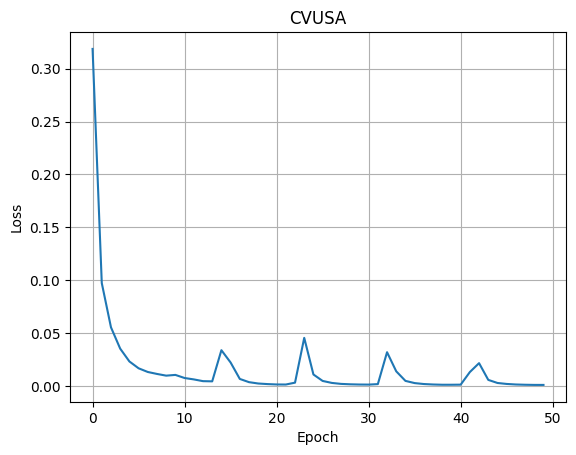

In [12]:
import pandas as pd
import matplotlib.pyplot as plt

# Read the CSV file into a pandas DataFrame
df = pd.read_csv('/data/Research/CVGL_Baseline/losses/losses_3588734.csv')

# Assuming the first column is x-axis and the second column is y-axis
x = df.iloc[:, 0]
y = df.iloc[:, 1]

# Plotting
plt.plot(x, y)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('CVUSA' )
plt.grid(True)
plt.show()


In [83]:
a = torch.rand(128, 1000)
b = torch.rand(128, 1000)


# a_norm = np.sqrt(np.sum(a**2, axis=1, keepdims=True))

a_norm = np.sqrt(np.sum((a**2).numpy(), axis=1, keepdims=True))
b_norm = np.sqrt(np.sum((b**2).numpy(), axis=1, keepdims=True))

sim = np.matmul(a/a_norm, (b/b_norm).T)
# torch.tensordot(a,b)
# (a@b.T).shape

# for i in range(128):
    # ranking = np.sum((sim[i,:]>sim[i,10])*1.)
    # print(ranking)
Q = len(a)
bar = tqdm(range(Q))
# np.sum(((sim[0]>0.755)*1.).numpy())


  0%|          | 0/128 [00:00<?, ?it/s]

In [10]:
from vit_pytorch import ViT
from vit_pytorch.deepvit import DeepViT


vit_r = DeepViT(
    image_size = 256,
    patch_size = 32,
    num_classes = 512,
    dim = 312,
    depth = 6,
    heads = 16,
    mlp_dim = 2048,
    dropout = 0.1,
    emb_dropout = 0.1
    )


print(vit_r)

DeepViT(
  (to_patch_embedding): Sequential(
    (0): Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1=32, p2=32)
    (1): LayerNorm((3072,), eps=1e-05, elementwise_affine=True)
    (2): Linear(in_features=3072, out_features=312, bias=True)
    (3): LayerNorm((312,), eps=1e-05, elementwise_affine=True)
  )
  (dropout): Dropout(p=0.1, inplace=False)
  (transformer): Transformer(
    (layers): ModuleList(
      (0-5): 6 x ModuleList(
        (0): Attention(
          (norm): LayerNorm((312,), eps=1e-05, elementwise_affine=True)
          (to_qkv): Linear(in_features=312, out_features=3072, bias=False)
          (dropout): Dropout(p=0.1, inplace=False)
          (reattn_norm): Sequential(
            (0): Rearrange('b h i j -> b i j h')
            (1): LayerNorm((16,), eps=1e-05, elementwise_affine=True)
            (2): Rearrange('b i j h -> b h i j')
          )
          (to_out): Sequential(
            (0): Linear(in_features=1024, out_features=312, bias=True)
            (1):

In [101]:
triplet_loss = nn.TripletMarginLoss(margin=1.0, p=2, eps=1e-7)
anchor = torch.randn(100, 128, requires_grad=True)
positive = torch.randn(100, 128, requires_grad=True)
negative = torch.randn(100, 128, requires_grad=True)
output = triplet_loss(anchor, positive, negative)
output.backward()

/home/fahimul/anaconda3/lib/python3.11/site-packages/torch/autograd/__init__.py:251: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 11070). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
